In [1]:
from main_lab import analyzer
models_7b = [
"Qwen/Qwen1.5-7B",
"meta-llama/Llama-2-7b-hf",
"deepseek-ai/deepseek-llm-7b-base",
"mistralai/Mistral-7B-v0.1"
]
models_mamba_like = [
    "tiiuae/falcon-mamba-7b",
]
models_small = [
"EleutherAI/pythia-2.8b",
"openai-community/gpt2-large"
]
from dataclasses import dataclass
@dataclass
class ArgumentParser:
    transform: str = "PCA"              # dimensionality reduction method: "PCA" or "PLS"
    Tdim: int = 1                       # number of target dimensions after transform
    k: int = 30                         # group/examples
    num_examples: int = 3               # number of demonstrations
    context: str = 'random'             # type of context (e.g., 'random' vs. fixed)
    data: str = 'numerics'              # dataset type to use numerics or symbols
    groups = [1,2,3,4]   # groups to test; here each group is 10**i
    upper_bound: int = 10**groups[-1]   # upper bound for generated numbers (max context size)
    save: bool = True                   # whether to save results
    plot: bool = True                   # whether to plot results
    model_name: str = models_small[1]  # model identifier (e.g., huggingface repo name)
    device: str = "0"                   # GPU device number (string)
    runs: int = 3                       # number of runs
args = ArgumentParser()

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
res = analyzer(args)
res.groups = [1,2,3,4,5]
for num_dem in [0, 1, 2,3]:
    acc = res.which_is_larger(num_dem=num_dem)
    # Append to table_3.txt
    with open("table_3.txt", "a") as f:
        f.write(f"{args.model_name} with number of demonstrations : {num_dem}\n")
        for line in acc:
            f.write(line + "\n")

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Accuracy for group 1 is: 0.01
Accuracy for group 2 is: 0.00
Accuracy for group 3 is: 0.08
Accuracy for group 4 is: 0.05
Accuracy for group 5 is: 0.11
Accuracy for group 1 is: 0.06
Accuracy for group 2 is: 0.03
Accuracy for group 3 is: 0.18
Accuracy for group 4 is: 0.05
Accuracy for group 5 is: 0.01
Accuracy for group 1 is: 0.27
Accuracy for group 2 is: 0.47
Accuracy for group 3 is: 0.63
Accuracy for group 4 is: 0.49
Accuracy for group 5 is: 0.36


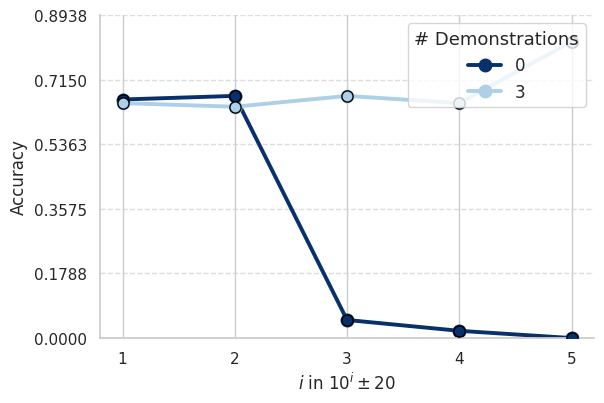

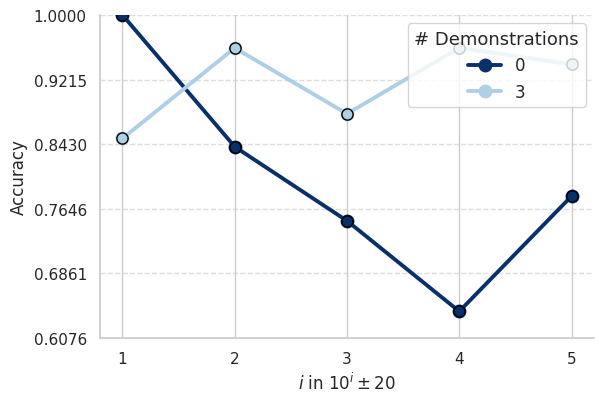

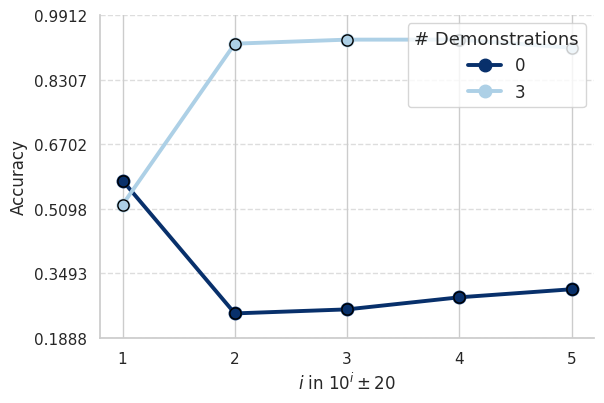

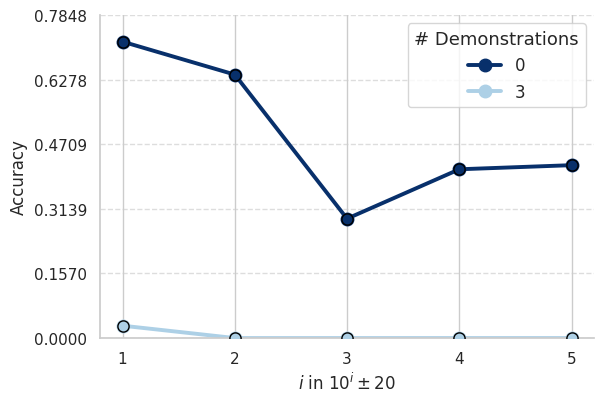

In [10]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import numpy as np

# Set up paper style: larger fonts, cleaner axes, color palette, serif fonts for ICLR submission
rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman", "Times", "CMU Serif"],
    "axes.titlesize": 18,
    "axes.labelsize": 24,
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
    "legend.fontsize": 24,
    "figure.titlesize": 20,
    "axes.linewidth": 1.5,
    "lines.linewidth": 3,
    "savefig.dpi": 300,
    "axes.grid": True,
    "axes.edgecolor": "#222222",
})
sns.set_theme(style='whitegrid', palette='Set2')

results_by_model = {}
with open("table_3.txt", "r") as f:
    lines = f.readlines()

current_model = None
current_dem = None

for line in lines:
    line = line.strip()
    if "with number of demonstrations" in line:
        if " with number of demonstrations" in line:
            parts = line.split(" with number of demonstrations")
            model = parts[0].strip()
            num_demo = int(line.split(":")[-1].strip())
            if num_demo not in [0, 1, 2, 3]:
                current_model = None
                current_dem = None
                continue
            current_model = model
            current_dem = num_demo
            if current_model not in results_by_model:
                results_by_model[current_model] = {}
            results_by_model[current_model][current_dem] = []
    elif (
        "Accuracy for group" in line 
        and current_model is not None 
        and current_dem is not None
        and current_dem in [0, 1, 2, 3]
    ):
        try:
            parts = line.split("is:")
            group_num = int(parts[0].split("group")[1].strip())
            accuracy = float(parts[1])
            results_by_model[current_model][current_dem].append((group_num, accuracy))
        except Exception:
            continue

# Only plot for 0 and 3 demonstration, keep color scheme
demos = [0, 3]
color_map = plt.get_cmap("Blues_r")
from matplotlib.colors import Normalize, to_rgb, to_hex

normalize = Normalize(vmin=min([0,3]), vmax=max([0,3]))
dem_colors = {}

# For 0 demos, use the mapped color as before
dem_colors[0] = color_map(normalize(0))

# For 3 demonstrations, start from Blues_r but make it a darker "blue"
# Instead of directly using the colormap, make it ~0.67 on the reversed blue scale (i.e., a darker blue)
# (Blues_r(0.67) ~ midpoint, darker than Blues_r(1.0), which is very light)
adjusted_dark_value = 0.67
dem_colors[3] = color_map(adjusted_dark_value)

dem_labels = {dem: f"{dem}" for dem in demos}

for model in results_by_model.keys():
    plt.figure(figsize=(6.2, 4.2))
    xs_plot = None  # Used for xticks at the end
    y_all = []
    for dem in demos:
        accs = results_by_model[model].get(dem, [])
        x_i = []
        y_acc = []
        for group_num, acc in sorted(accs):
            x_i.append(group_num)
            y_acc.append(acc)
        xs_plot = x_i if xs_plot is None or len(x_i) > len(xs_plot) else xs_plot
        if x_i:
            plt.plot(
                x_i, y_acc,
                marker="o", markersize=9,
                color=dem_colors[dem],
                label=dem_labels[dem],
                linewidth=2.8,
            )
            plt.scatter(x_i, y_acc, color=dem_colors[dem], s=65, edgecolor="k", zorder=5)
            y_all.extend(y_acc)

    # Y axis range: just below the minimum, just above the maximum
    if y_all:
        min_y = min(y_all)
        max_y = max(y_all)
        y_pad = max(0.03, (max_y - min_y)*0.09)
        ylim_bottom = max(0.0, min_y - y_pad)
        ylim_top = min(1.0, max_y + y_pad)
        plt.ylim(ylim_bottom, ylim_top)
    else:
        plt.ylim(-0.05, 1.05)

    # --- Format x-axis as 'i' not 10^i -- # Provide text about 10^i ± 20 (in caption/legend)
    plt.xlabel(r"$i$ in $10^{i} \pm 20$")
    plt.ylabel("Accuracy")
    # plt.title(f"{model.replace('-', ' ').replace('/', ' ').title()}", pad=14)
    xtick_vals = xs_plot if xs_plot is not None and len(xs_plot) > 0 else [1,2,3,4,5]
    plt.xticks(xtick_vals, [str(i) for i in xtick_vals])
    plt.yticks(np.linspace(plt.ylim()[0], plt.ylim()[1], 6))
    plt.grid(axis="y", linestyle="--", alpha=0.65)
    plt.legend(loc="upper right", frameon=True, fancybox=True, fontsize=12, title="# Demonstrations", title_fontsize=13)
    sns.despine(left=False, bottom=False)
    plt.tight_layout()
    # Save with clean name, suitable for paper
    safe_model_name = model.lower().replace("/", "_").replace("-", "_").replace(" ", "_")
    plt.savefig(f"ICLR_results/which_results/fig_{safe_model_name}_which_is_larger_iclr.pdf", bbox_inches="tight")
    # plt.savefig(f"ICLR_results/which_results/fig_{safe_model_name}_which_is_larger_iclr.png", bbox_inches="tight")
    #plt.close()
